In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(a, mu, sigma_z1, sigma_z2, enc_t=0, mot_t=0, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    
    ndt = enc_t + mot_t
    return ndt+rt, theta, np.random.normal(enc_t, sigma_z1), np.random.normal(mot_t, sigma_z2)

In [3]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            if a(j*dt) == 0:
                continue
            
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [4]:
def HSDM_2D_likelihood(prms, RT, Theta, Z1, Z2):
    a = lambda t: prms[0]/(1 + prms[1]*t)
    a2 = lambda t: (a(t))**2
    da2 = lambda t: -2*prms[1]*prms[0]/(1 + prms[1]*t)**2 * a(t)
    
    ndt = prms[2]
    mu = np.array([prms[3], prms[4]])
    sig = prms[5]
        
    T_max = max(RT)
    fpt = ie_bessel_fpt(a2, da2, mu.shape[0], 0.000001, 
                        dt=0.05, T_max=T_max)
        
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = a(rt - ndt) * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)

            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            if 0.1**14 < density:
                log_lik += -np.log(density) + 0.5*(Z1[i] + Z2[i] - ndt)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            else:
                log_lik += -np.log(0.1**14) + 0.5*(Z1[i] + Z2[i] - ndt)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [5]:
recovery_dic = {'b0_true': [],
                'b0_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'ndt_true': [],
                'ndt_estimate': [],
                'mu1_true': [],
                'mu1_estimate': [],
                'mu2_true': [],
                'mu2_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[]}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1.2

min_mu = -3
max_mu = 3

In [11]:
for n in tqdm(range(95)):
    b0 = np.random.uniform(min_b0, max_b0)
    lamb = np.random.uniform(min_lambda, max_lambda)
    a = lambda t: b0 /(1 + lamb*t)
    
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu)])
    
    sigma_z1 = np.random.uniform(0.05, 0.4)
    sigma_z2 = np.random.uniform(0.05, 0.4)
    enc_t = np.random.uniform(0.05, .6)
    mot_t = np.random.uniform(0.05, .6)
    
    RT = []
    Theta = []
    Z1 = []
    Z2 = []
    
    for i in range(500):
        rt, theta, z1, z2 = simulate_HSDM_2D(a, mu, sigma_z1, sigma_z2, enc_t=enc_t, mot_t=mot_t)
        RT.append(rt)
        Theta.append(theta)
        Z1.append(z1)
        Z2.append(z2)
    
    min_ans = differential_evolution(HSDM_2D_likelihood,
                                     args=(RT, Theta, Z1, Z2),
                                     bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                             (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                                             (0.05, 0.6)])
    
    min_ans = minimize(HSDM_2D_likelihood,
                       args=(RT, Theta, Z1, Z2),
                       method='nelder-mead',
                       x0=min_ans.x,
                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda),
                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                               (0.05, 0.6)])
    
    if min_ans.success:
        recovery_dic['b0_true'].append(b0)
        recovery_dic['lambda_true'].append(lamb)
        recovery_dic['ndt_true'].append(enc_t + mot_t)
        recovery_dic['mu1_true'].append(mu[0])
        recovery_dic['mu2_true'].append(mu[1])
        recovery_dic['sigma_true'].append(np.sqrt(sigma_z1**2 + sigma_z2**2))

        recovery_dic['b0_estimate'].append(min_ans.x[0])
        recovery_dic['lambda_estimate'].append(min_ans.x[1])
        recovery_dic['ndt_estimate'].append(min_ans.x[2])
        recovery_dic['mu1_estimate'].append(min_ans.x[3])
        recovery_dic['mu2_estimate'].append(min_ans.x[4])
        recovery_dic['sigma_estimate'].append(min_ans.x[5])

100%|█████████████████████████████████████████| 95/95 [2:37:27<00:00, 99.45s/it]


In [12]:
recovery_df = pd.DataFrame(recovery_dic)

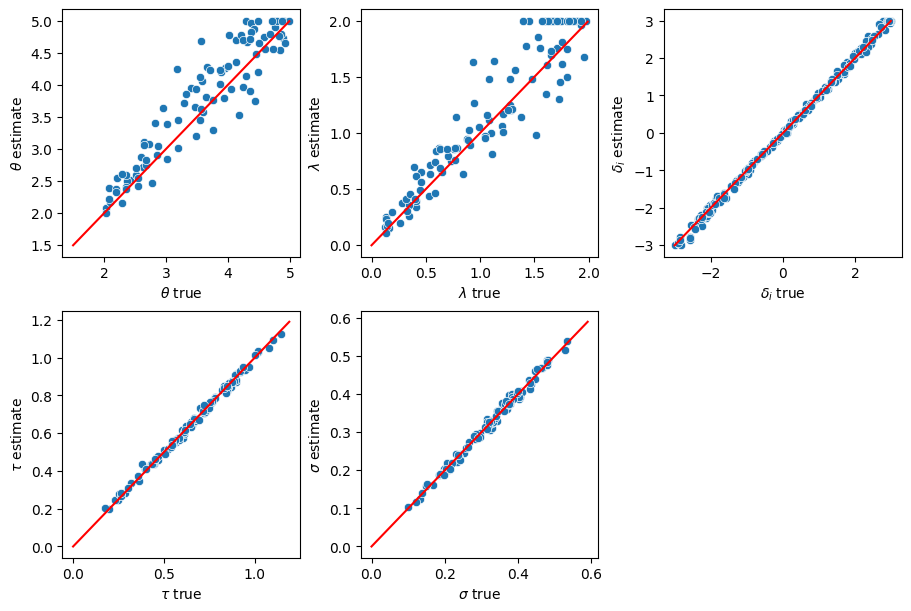

In [13]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 5, 0.01), np.arange(1.5, 5, 0.01), c='red')
sns.scatterplot(x='b0_true', y='b0_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(-3, 3, 0.01), np.arange(-3, 3, 0.01), c='red')
sns.scatterplot(x='mu1_true', y='mu1_estimate', data=recovery_df);
sns.scatterplot(x='mu2_true', y='mu2_estimate', data=recovery_df, c='tab:blue');
plt.xlabel(r'$\delta_i$ true')
plt.ylabel(r'$\delta_i$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1.2, 0.01), np.arange(0, 1.2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate');

plt.subplot(235)
plt.plot(np.arange(0, .6, 0.01), np.arange(0, .6, 0.01), c='red')
sns.scatterplot(x='sigma_true', y='sigma_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');

In [14]:
print(recovery_df.shape)
recovery_df.corr()

(100, 12)


,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
b0_true,1.000000,0.940892,-0.073658,-0.139706,-0.072047,-0.061134,-0.007647,-0.007235,0.066747,0.069741,-0.096382,-0.092442
b0_estimate,0.940892,1.000000,-0.076905,-0.039795,-0.035548,-0.036281,-0.001089,0.000856,0.088610,0.091236,-0.069513,-0.066382
lambda_true,-0.073658,-0.076905,1.000000,0.936658,-0.078242,-0.074727,-0.091649,-0.091835,-0.250809,-0.255400,0.095530,0.104816
lambda_estimate,-0.139706,-0.039795,0.936658,1.000000,-0.063220,-0.066627,-0.109651,-0.109211,-0.230571,-0.234700,0.112898,0.120832
ndt_true,-0.072047,-0.035548,-0.078242,-0.063220,1.000000,0.997999,-0.012125,-0.013719,0.103861,0.105554,0.100269,0.118874
ndt_estimate,-0.061134,-0.036281,-0.074727,-0.066627,0.997999,1.000000,-0.017727,-0.019503,0.107406,0.108839,0.101403,0.120544
mu1_true,-0.007647,-0.001089,-0.091649,-0.109651,-0.012125,-0.017727,1.000000,0.999095,-0.021774,-0.021285,0.163201,0.158572
mu1_estimate,-0.007235,0.000856,-0.091835,-0.109211,-0.013719,-0.019503,0.999095,1.000000,-0.016006,-0.015726,0.165670,0.160772
mu2_true,0.066747,0.088610,-0.250809,-0.230571,0.103861,0.107406,-0.021774,-0.016006,1.000000,0.999261,-0.042317,-0.033332
mu2_estimate,0.069741,0.091236,-0.255400,-0.234700,0.105554,0.108839,-0.021285,-0.015726,0.999261,1.000000,-0.045802,-0.037052


In [15]:
recovery_df.to_csv('Hyperbolic_rec.csv')